**Data augmentation modelos de atención**

<p align="justify">En este capítulo vamos a realizar Data augmentation en los modelos de atención usados para la clasificación en el capítulo anterior.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import re
import string
import unicodedata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
df = pd.read_csv('/Users/34653/Downloads/new_dataset.csv')
df.head()

,label,message
0,Solicitud de informacion,"Hola buenos dias, una amiga mia que esta hacie..."
1,Solicitud de informacion,Hola Mary Quiero apuntarme al curso de las pil...
2,Solicitud de informacion,"Hola! Soy Rocio, me gustaria recibir informaci..."
3,Solicitud de informacion,"Hola , buenas noches \nSoy enfermera y estaria..."
4,Solicitud de informacion,"Buenos dias Felices reyes,estaria interesada e..."


<p align="justify">El método de Data augmentation que vamos a usar es BackTranslation que traduce nuestro texto a otro idioma para volver al idioma original, de esta manera se habrán reemplazado algunas palabras por sus sinónimos manteniendo el significado original del texto.

Procesando...  1 / 69
Procesando...  2 / 69
Procesando...  3 / 69
Procesando...  4 / 69
Procesando...  5 / 69
Procesando...  6 / 69
Procesando...  7 / 69
Procesando...  8 / 69
Procesando...  9 / 69
Procesando...  10 / 69
Procesando...  11 / 69
Procesando...  12 / 69
Procesando...  13 / 69
Procesando...  14 / 69
Procesando...  15 / 69
Procesando...  16 / 69
Procesando...  17 / 69
Procesando...  18 / 69
Procesando...  19 / 69
Procesando...  20 / 69
Procesando...  21 / 69
Procesando...  22 / 69
Procesando...  23 / 69
Procesando...  24 / 69
Procesando...  25 / 69
Procesando...  26 / 69
Procesando...  27 / 69
Procesando...  28 / 69
Procesando...  29 / 69
Procesando...  30 / 69
Procesando...  31 / 69
Procesando...  32 / 69
Procesando...  33 / 69
Procesando...  34 / 69
Procesando...  35 / 69
Procesando...  36 / 69
Procesando...  37 / 69
Procesando...  38 / 69
Procesando...  39 / 69
Procesando...  40 / 69
Procesando...  41 / 69
Procesando...  42 / 69
Procesando...  43 / 69
Procesando...  44 / 

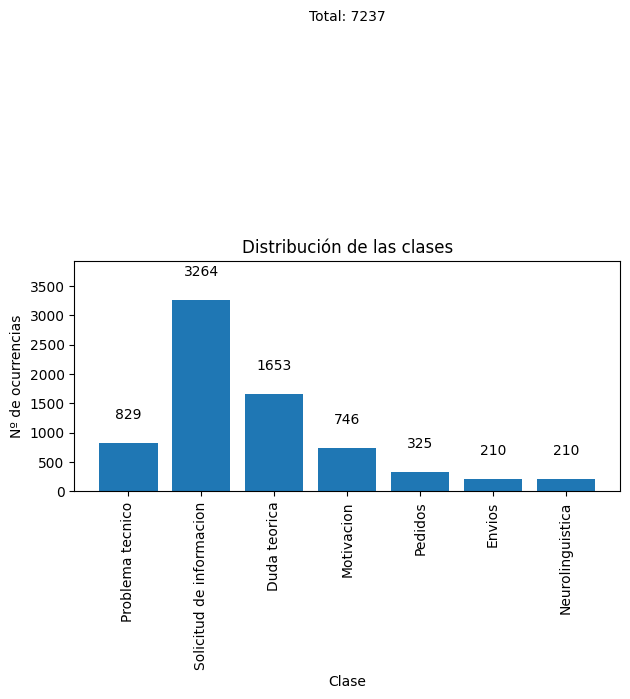

In [ ]:
from BackTranslation import BackTranslation

# Creamos la función auxiliar para reemplazar las abreviaciones
def replace_abbreviations(text, abbreviations):

    for key, value in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(key), value, text)
    return text


abbreviations = {
    'x' : 'por',
    'xq': 'porque',
    'pq': 'porque',
    'k': 'que',
    'tb': 'también',
    'tmb': 'también',
    'd': 'de',
    'cn': 'con',
    'm': 'me',
    'q': 'que',
    'qe': 'que',
    't': 'te',
}


# Creamos la función para preprocesar y tokenizar el dataset
def preprocess_spanish(text):

  # Pasamos todo el texto a minúsculas
  text = text.lower()

  # Reemplazamos las abreviaciones
  text = replace_abbreviations(text, abbreviations)

  # Borramos las URL que puedan contener los mensajes
  text = re.sub('https:\/\/\S+', '', text)

  # Cargamos una lista de signos de puntuación para eliminarlos al preprocesar
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

  # Borramos los saltos de línea
  text = re.sub(r'[^ \w\.]', '', text)

  # Reemplazamos las letras acentuadas por sus equivalentes no acentuadas
  text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

  return text

# Creamos una nueva columna llamada "Text" con el texto procesado
df['Text'] = df.message.apply(lambda x: preprocess_spanish(x))

# Dividir el conjunto de datos en entrenamiento (75%) y temporal (25%)
train_df, temp_df = train_test_split(df, test_size=0.25, random_state=42, stratify=df['label'])

# Dividir el conjunto temporal en validación (40% de 25% = 10% del total) y prueba (60% de 25% = 15% del total)
valid_df, test_df = train_test_split(temp_df, test_size=0.6, random_state=42, stratify=temp_df['label'])



# Calcular el número total de filas en train_df
total_rows_train = len(train_df)

# Calcular el número de filas para cada etiqueta en train_df
label_counts_train = train_df['label'].value_counts()

# Identificar las etiquetas que están por debajo del umbral en train_df
underrepresented_labels_train = label_counts_train[label_counts_train/total_rows_train < 0.03].index

trans = BackTranslation(url=[
      'translate.google.com',
      'translate.google.co.kr',
    ], proxies={'http': '127.0.0.1:1234', 'http://host.name': '127.0.0.1:4012'})

# Por cada etiqueta bajo-representada en train_df, traducir y añadir filas
for label in underrepresented_labels_train:
    # Filtrar el train_df para solo esta etiqueta
    label_df_train = train_df[train_df['label'] == label]

    # Determinar cuántas filas debes añadir para llegar al 3% en train_df
    rows_to_add_train = int(0.03 * total_rows_train) - len(label_df_train)

    # Traducir y añadir las filas necesarias al train_df
    for i in range(rows_to_add_train):
        print("Procesando... ", i+1, "/", rows_to_add_train)
        # Seleccionar una fila aleatoria de este subconjunto en train_df
        row_to_translate_train = label_df_train.sample(1)

        # Traducir la fila
        translated_row_train = pd.DataFrame({
            'label': [row_to_translate_train['label'].values[0]],
            'message': [row_to_translate_train['message'].values[0]],
            'Text': [preprocess_spanish(trans.translate(row_to_translate_train['Text'].values[0], src='es', tmp = 'fr').result_text)],
        })

        # Añadir la fila traducida al train_df original
        train_df = pd.concat([train_df, translated_row_train], ignore_index=True)

def show_labels_ocurrences(dataset):
    label_ocurrences = Counter(dataset['label'])  # Cambio de 'labels' a 'label'
    labels, ocurrences = zip(*label_ocurrences.items())
    total = sum(ocurrences)

    plt.bar(labels, ocurrences)
    plt.xlabel('Clase')
    plt.ylabel('Nº de ocurrencias')
    plt.title('Distribución de las clases')
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Añadimos el número de ocurrencias de cada clase
    for i, count in enumerate(ocurrences):
        plt.text(i, count+0.05*total, str(count), ha='center', va='bottom')
    plt.text(len(labels)//2, 1.1*total, f'Total: {total}', ha='center', va='bottom')
    plt.ylim(0, 1.2*max(ocurrences))
    plt.show()  # Añadido para mostrar la gráfica

# Mostrar la distribución de clases en train_df usando la función adaptada
show_labels_ocurrences(train_df)


In [ ]:
from transformers import AutoTokenizer
tokenizer_roberta = AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-bne')
tokenizer_bert = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

C:\Users\34653\anaconda3\envs\colab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Mostramos un ejemplo de codificación
print({x : tokenizer_roberta.encode(x, add_special_tokens=False) for x in train_df.Text.values[0].split()})
print({x : tokenizer_bert.encode(x, add_special_tokens=False) for x in train_df.Text.values[0].split()})

{'en': [318], 'la': [407], 'playaforma': [6549, 1322, 2559], 'las': [610], 'dudas': [122, 7380], 'no': [552], 'se': [483], 'contestan': [562, 435, 444], 'a': [119], 'eso': [4146], 'me': [1060], 'refiero': [16226, 7762], 'gracias': [16618]}
{'en': [1035], 'la': [1032], 'playaforma': [6185, 6150], 'las': [1085], 'dudas': [9191], 'no': [1054], 'se': [1057], 'contestan': [13238, 30959], 'a': [1012], 'eso': [1250], 'me': [1094], 'refiero': [8303], 'gracias': [1542]}


<p align='justify'>Para poder elegir correctamente el parámetro de máxima longitud, vamos a analizar la longitud (en tokens) de nuestro dataset. Es importante evaluar correctamente este parámetro ya que necesitamos un valor lo suficientemente grande para poder entrenar de manera correcta el modelo, pero que no tenga un coste computacional muy alto que perjudique el entrenamiento (cuanto más alto es el valor del parámetro mayor tiempo de entrenamiento).

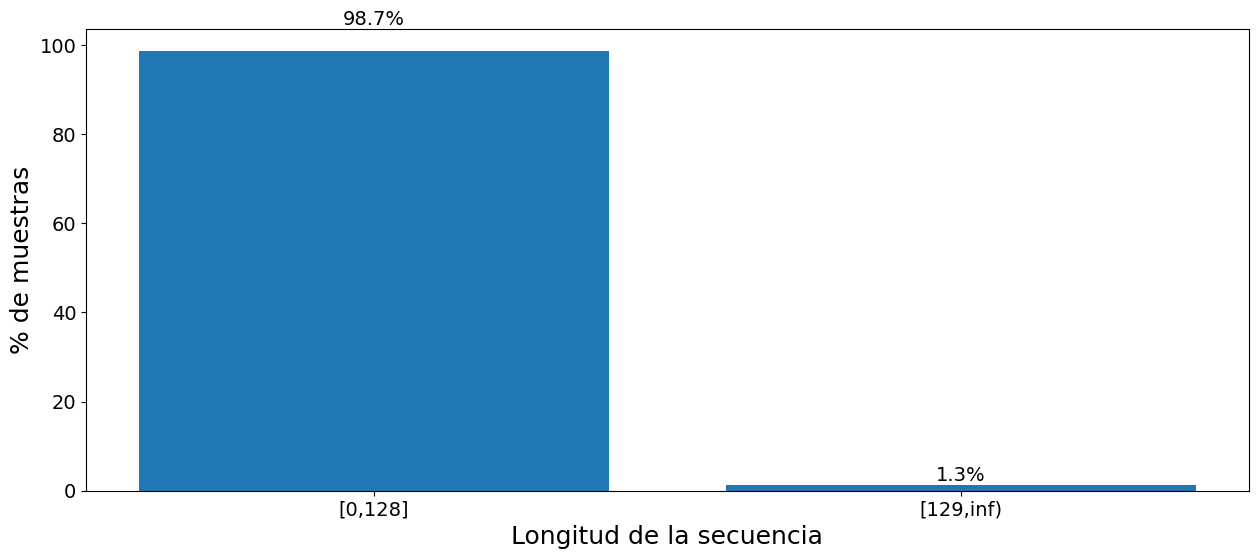

In [ ]:
# Tokenizamos los textos
tokenized_roberta_feature_train = tokenizer_roberta.batch_encode_plus(
                            # Texto que se codifica
                            train_df.Text.values.tolist(),
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True
                   )

# Obtenemos las longitudes de los textos
token_sentence_length = [len(x) for x in tokenized_roberta_feature_train['input_ids']]
import numpy as np
import matplotlib.pyplot as plt

# Definimos los intervalos
bins = [0, 128, max(token_sentence_length) + 1]  # +1 to include the upper bound

# Obtenemos los totales de cada intervalo
counts, _ = np.histogram(token_sentence_length, bins=bins)

# Calculamos los porcentajes
percentages = (counts / sum(counts)) * 100

# Pintamos el diagrama de barras
plt.figure(figsize=(15, 6))
bar_plot = plt.bar(range(len(bins)-1), percentages, tick_label=['[0,128]', '[129,inf)'])

plt.xlabel('Longitud de la secuencia', fontsize = 18)
plt.ylabel('% de muestras', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Añadimos los porcentajes
for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
             f'{percentages[idx]:.1f}%',
             ha='center', va='bottom', fontsize=14)

plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors


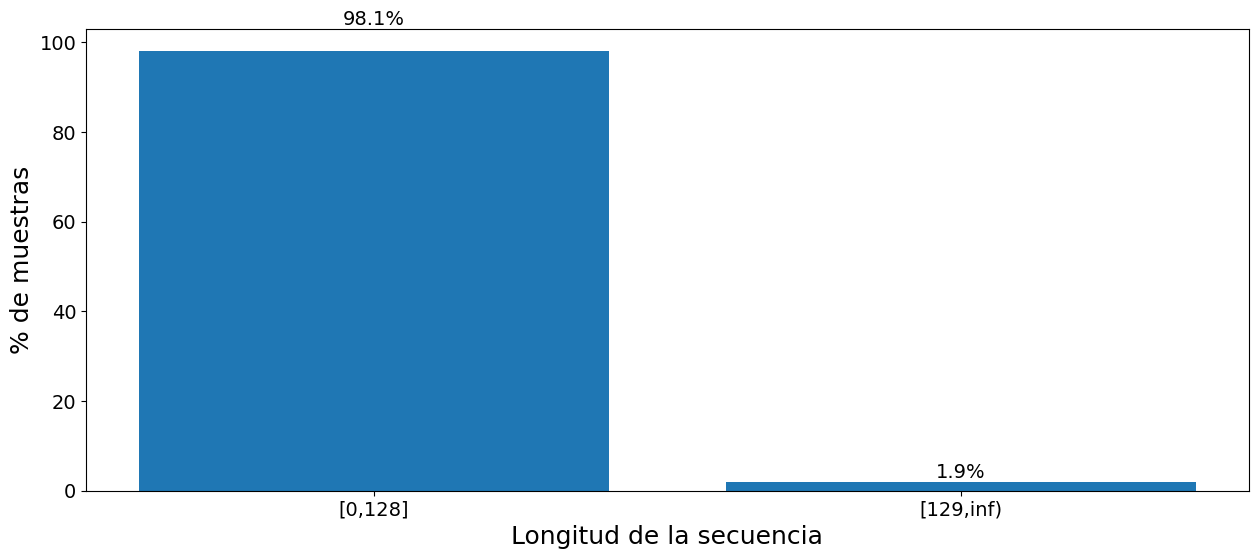

In [ ]:
# Tokenizamos los textos
tokenized_roberta_feature_valid = tokenizer_roberta.batch_encode_plus(
                            # Texto que se codifica
                            valid_df.Text.values.tolist(),
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True
                   )

# Obtenemos las longitudes de los textos
token_sentence_length = [len(x) for x in tokenized_roberta_feature_valid['input_ids']]
import numpy as np
import matplotlib.pyplot as plt

# Definimos los intervalos
bins = [0, 128, max(token_sentence_length) + 1]  # +1 to include the upper bound

# Obtenemos los totales de cada intervalo
counts, _ = np.histogram(token_sentence_length, bins=bins)

# Calculamos los porcentajes
percentages = (counts / sum(counts)) * 100

# Pintamos el diagrama de barras
plt.figure(figsize=(15, 6))
bar_plot = plt.bar(range(len(bins)-1), percentages, tick_label=['[0,128]', '[129,inf)'])

plt.xlabel('Longitud de la secuencia', fontsize = 18)
plt.ylabel('% de muestras', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Añadimos los porcentajes
for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
             f'{percentages[idx]:.1f}%',
             ha='center', va='bottom', fontsize=14)

plt.show()

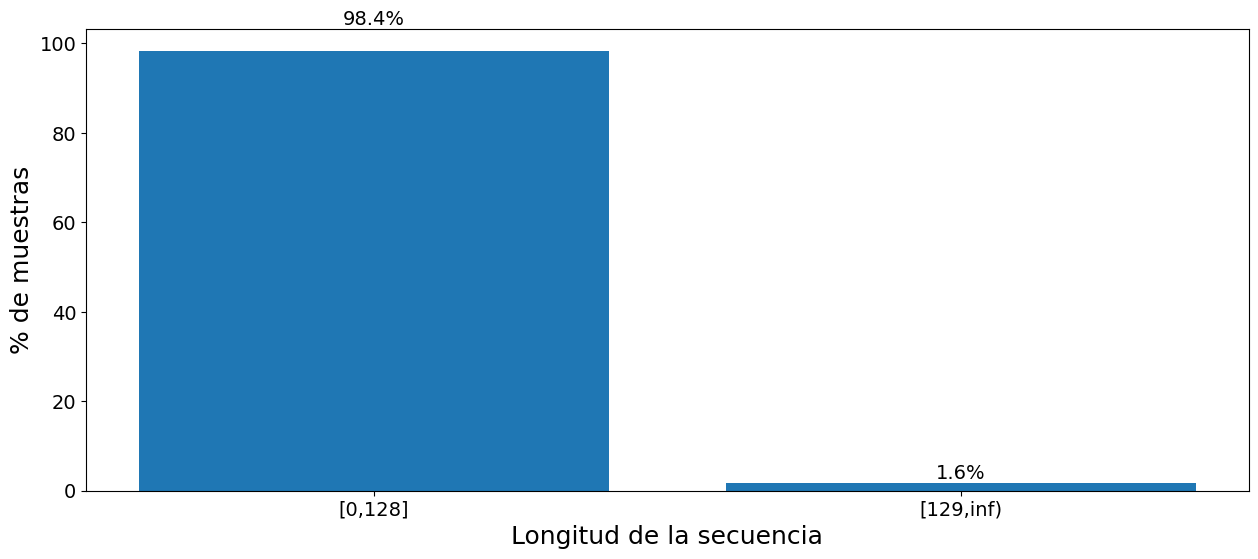

In [ ]:
# Tokenizamos los textos
tokenized_roberta_feature_test = tokenizer_roberta.batch_encode_plus(
                            # Texto que se codifica
                            test_df.Text.values.tolist(),
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True
                   )

# Obtenemos las longitudes de los textos
token_sentence_length = [len(x) for x in tokenized_roberta_feature_test['input_ids']]
import numpy as np
import matplotlib.pyplot as plt

# Definimos los intervalos
bins = [0, 128, max(token_sentence_length) + 1]  # +1 to include the upper bound

# Obtenemos los totales de cada intervalo
counts, _ = np.histogram(token_sentence_length, bins=bins)

# Calculamos los porcentajes
percentages = (counts / sum(counts)) * 100

# Pintamos el diagrama de barras
plt.figure(figsize=(15, 6))
bar_plot = plt.bar(range(len(bins)-1), percentages, tick_label=['[0,128]', '[129,inf)'])

plt.xlabel('Longitud de la secuencia', fontsize = 18)
plt.ylabel('% de muestras', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Añadimos los porcentajes
for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
             f'{percentages[idx]:.1f}%',
             ha='center', va='bottom', fontsize=14)

plt.show()

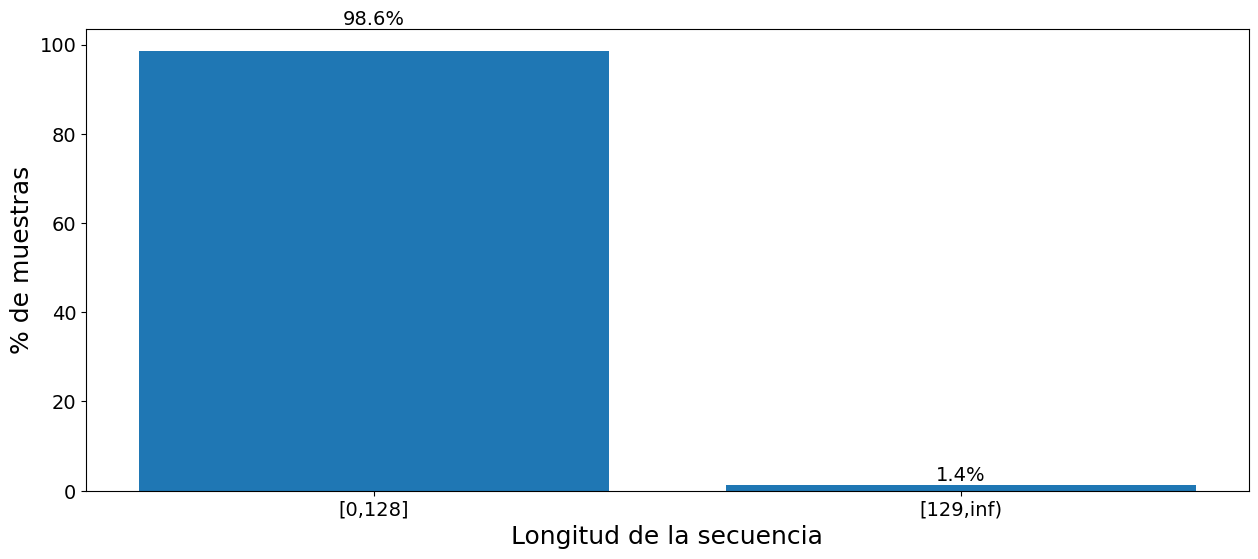

In [ ]:
# Tokenizamos los textos
tokenized_bert_feature_train = tokenizer_bert.batch_encode_plus(
                            # Texto que se codifica
                            train_df.Text.values.tolist(),
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True
                   )

# Obtenemos las longitudes de los textos
token_sentence_length = [len(x) for x in tokenized_bert_feature_train['input_ids']]
import numpy as np
import matplotlib.pyplot as plt

# Definimos los intervalos
bins = [0, 128, max(token_sentence_length) + 1]  # +1 to include the upper bound

# Obtenemos los totales de cada intervalo
counts, _ = np.histogram(token_sentence_length, bins=bins)

# Calculamos los porcentajes
percentages = (counts / sum(counts)) * 100

# Pintamos el diagrama de barras
plt.figure(figsize=(15, 6))
bar_plot = plt.bar(range(len(bins)-1), percentages, tick_label=['[0,128]', '[129,inf)'])

plt.xlabel('Longitud de la secuencia', fontsize = 18)
plt.ylabel('% de muestras', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Añadimos los porcentajes
for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
             f'{percentages[idx]:.1f}%',
             ha='center', va='bottom', fontsize=14)

plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


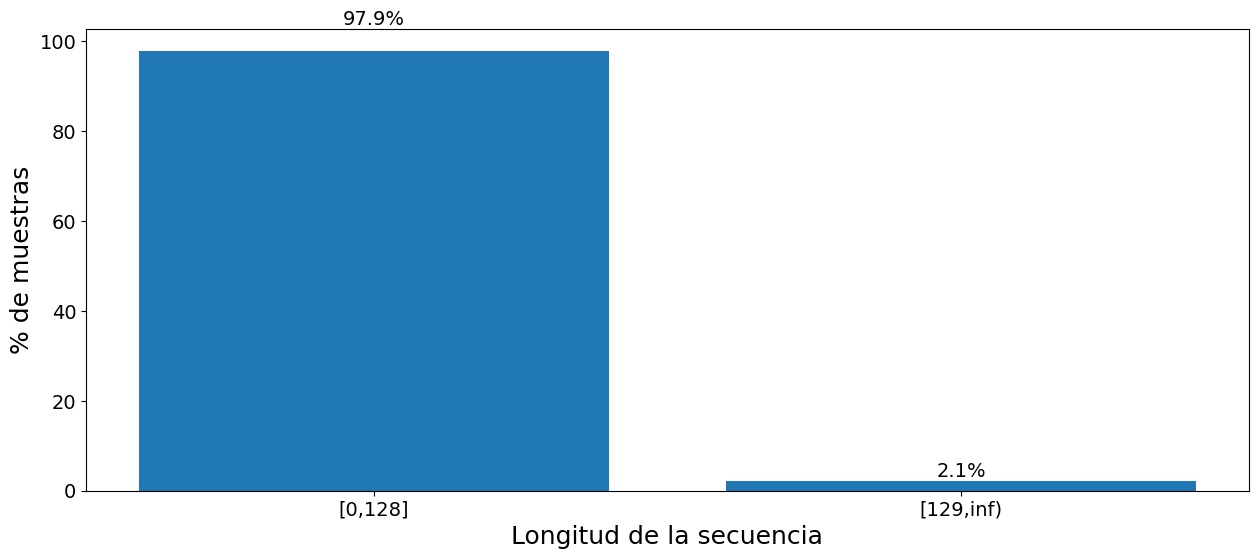

In [ ]:
# Tokenizamos los textos
tokenized_bert_feature_val = tokenizer_bert.batch_encode_plus(
                            # Texto que se codifica
                            valid_df.Text.values.tolist(),
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True
                   )

# Obtenemos las longitudes de los textos
token_sentence_length = [len(x) for x in tokenized_bert_feature_val['input_ids']]
import numpy as np
import matplotlib.pyplot as plt

# Definimos los intervalos
bins = [0, 128, max(token_sentence_length) + 1]  # +1 to include the upper bound

# Obtenemos los totales de cada intervalo
counts, _ = np.histogram(token_sentence_length, bins=bins)

# Calculamos los porcentajes
percentages = (counts / sum(counts)) * 100

# Pintamos el diagrama de barras
plt.figure(figsize=(15, 6))
bar_plot = plt.bar(range(len(bins)-1), percentages, tick_label=['[0,128]', '[129,inf)'])

plt.xlabel('Longitud de la secuencia', fontsize = 18)
plt.ylabel('% de muestras', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Añadimos los porcentajes
for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
             f'{percentages[idx]:.1f}%',
             ha='center', va='bottom', fontsize=14)

plt.show()

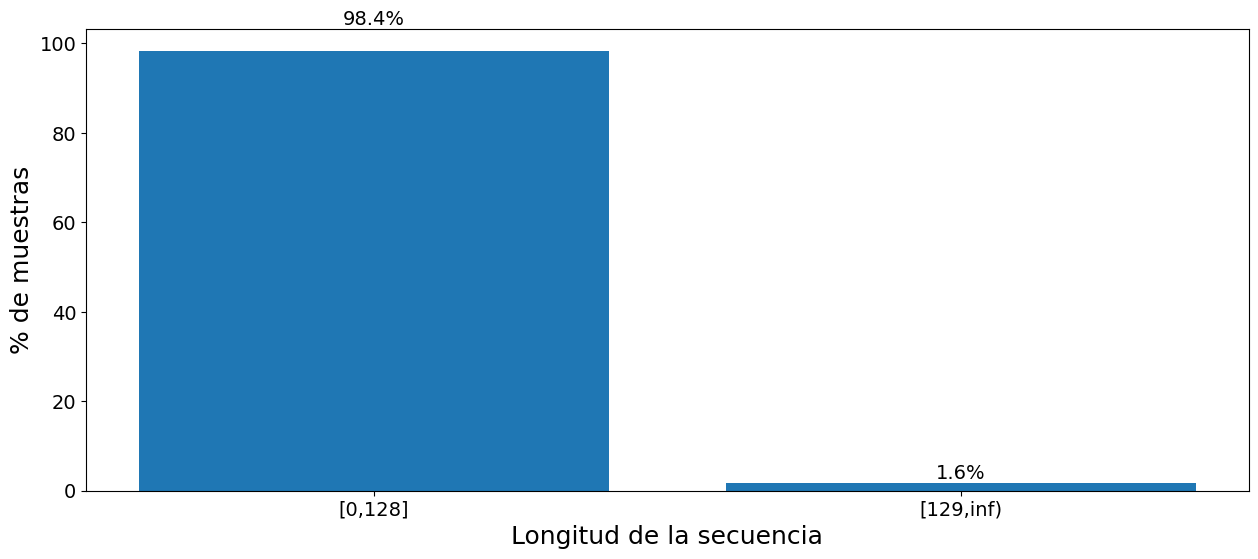

In [ ]:
# Tokenizamos los textos
tokenized_bert_feature_test = tokenizer_bert.batch_encode_plus(
                            # Texto que se codifica
                            test_df.Text.values.tolist(),
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True
                   )

# Obtenemos las longitudes de los textos
token_sentence_length = [len(x) for x in tokenized_bert_feature_test['input_ids']]
import numpy as np
import matplotlib.pyplot as plt

# Definimos los intervalos
bins = [0, 128, max(token_sentence_length) + 1]  # +1 to include the upper bound

# Obtenemos los totales de cada intervalo
counts, _ = np.histogram(token_sentence_length, bins=bins)

# Calculamos los porcentajes
percentages = (counts / sum(counts)) * 100

# Pintamos el diagrama de barras
plt.figure(figsize=(15, 6))
bar_plot = plt.bar(range(len(bins)-1), percentages, tick_label=['[0,128]', '[129,inf)'])

plt.xlabel('Longitud de la secuencia', fontsize = 18)
plt.ylabel('% de muestras', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Añadimos los porcentajes
for idx, rect in enumerate(bar_plot):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
             f'{percentages[idx]:.1f}%',
             ha='center', va='bottom', fontsize=14)

plt.show()

<p align='justify'>Como se puede apreciar en los gráficos anteriores más del 98% de nuestros datos se ubican en el intervalo [0,128] en su longitud en tokens, por lo que el parámetro que vamos a usar como longitud máxima es 128.

In [ ]:
features_train = train_df.message.values.tolist()
target_train =   train_df.label.values.tolist()

In [ ]:
features_val = valid_df.message.values.tolist()
target_val = valid_df.label.values.tolist()

In [ ]:
features_test = test_df.message.values.tolist()
target_test =   test_df.label.values.tolist()

In [ ]:
MAX_LEN = 128
tokenized_features_roberta_train = tokenizer_roberta.batch_encode_plus(
                            # Texto que se codifica
                            features_train,
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True,
                            # Añadimos padding para textos cuya longitud sea < 128
                            padding = 'max_length',
                            # Truncamos los textos cuya longitud sea > 128
                            truncation=True,
                            # Fijamos la longitud máxima
                            max_length = MAX_LEN,
                            # Return de las máscaras de atención
                            return_attention_mask = True,
                            # Return de los tensores de pytorch
                            return_tensors = 'pt'
                   )

In [ ]:
MAX_LEN = 128
tokenized_features_roberta_val = tokenizer_roberta.batch_encode_plus(
                            # Texto que se codifica
                            features_val,
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True,
                            # Añadimos padding para textos cuya longitud sea < 128
                            padding = 'max_length',
                            # Truncamos los textos cuya longitud sea > 128
                            truncation=True,
                            # Fijamos la longitud máxima
                            max_length = MAX_LEN,
                            # Return de las máscaras de atención
                            return_attention_mask = True,
                            # Return de los tensores de pytorch
                            return_tensors = 'pt'
                   )

In [ ]:
MAX_LEN = 128
tokenized_features_roberta_test = tokenizer_roberta.batch_encode_plus(
                            # Texto que se codifica
                            features_test,
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True,
                            # Añadimos padding para textos cuya longitud sea < 128
                            padding = 'max_length',
                            # Truncamos los textos cuya longitud sea > 128
                            truncation=True,
                            # Fijamos la longitud máxima
                            max_length = MAX_LEN,
                            # Return de las máscaras de atención
                            return_attention_mask = True,
                            # Return de los tensores de pytorch
                            return_tensors = 'pt'
                   )

In [ ]:
MAX_LEN = 128
tokenized_features_bert_train = tokenizer_bert.batch_encode_plus(
                            # Texto que se codifica
                            features_train,
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True,
                            # Añadimos padding para textos cuya longitud sea < 128
                            padding = 'max_length',
                            # Truncamos los textos cuya longitud sea > 128
                            truncation=True,
                            # Fijamos la longitud máxima
                            max_length = MAX_LEN,
                            # Return de las máscaras de atención
                            return_attention_mask = True,
                            # Return de los tensores de pytorch
                            return_tensors = 'pt'
                   )

In [ ]:
MAX_LEN = 128
tokenized_features_bert_val = tokenizer_bert.batch_encode_plus(
                            # Texto que se codifica
                            features_val,
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True,
                            # Añadimos padding para textos cuya longitud sea < 128
                            padding = 'max_length',
                            # Truncamos los textos cuya longitud sea > 128
                            truncation=True,
                            # Fijamos la longitud máxima
                            max_length = MAX_LEN,
                            # Return de las máscaras de atención
                            return_attention_mask = True,
                            # Return de los tensores de pytorch
                            return_tensors = 'pt'
                   )

In [ ]:
MAX_LEN = 128
tokenized_features_bert_test = tokenizer_bert.batch_encode_plus(
                            # Texto que se codifica
                            features_test,
                            # Añadimos '[CLS]' y '[SEP]' (tokens especiales)
                            add_special_tokens = True,
                            # Añadimos padding para textos cuya longitud sea < 128
                            padding = 'max_length',
                            # Truncamos los textos cuya longitud sea > 128
                            truncation=True,
                            # Fijamos la longitud máxima
                            max_length = MAX_LEN,
                            # Return de las máscaras de atención
                            return_attention_mask = True,
                            # Return de los tensores de pytorch
                            return_tensors = 'pt'
                   )

In [ ]:
# Convertimos las etiquetas en valores numéricos
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target_train)
target_train_num = le.transform(target_train)
target_val_num = le.transform(target_val)
target_test_num = le.transform(target_test)

In [ ]:
# Definimos el tamaño de batch
batch_size = 4

# DataLoader para roberta train
train_roberta_data = TensorDataset(tokenized_features_roberta_train['input_ids'], tokenized_features_roberta_train['attention_mask'], torch.tensor(target_train_num))
train_roberta_sampler = RandomSampler(train_roberta_data)
train_roberta_dataloader = DataLoader(train_roberta_data, sampler=train_roberta_sampler, batch_size=batch_size)

# DataLoader para roberta validación
val_roberta_data = TensorDataset(tokenized_features_roberta_val['input_ids'], tokenized_features_roberta_val['attention_mask'], torch.tensor(target_val_num))
val_roberta_sampler = SequentialSampler(val_roberta_data)
val_roberta_dataloader = DataLoader(val_roberta_data, sampler=val_roberta_sampler, batch_size=batch_size)

# DataLoader para roberta test
test_roberta_data = TensorDataset(tokenized_features_roberta_test['input_ids'], tokenized_features_roberta_test['attention_mask'], torch.tensor(target_test_num))
test_roberta_sampler = SequentialSampler(test_roberta_data)
test_roberta_dataloader = DataLoader(test_roberta_data, sampler=test_roberta_sampler, batch_size=batch_size)

In [ ]:
# Definimos el tamaño de batch
batch_size = 4

# DataLoader para bert train
train_bert_data = TensorDataset(tokenized_features_bert_train['input_ids'], tokenized_features_bert_train['attention_mask'], torch.tensor(target_train_num))
train_bert_sampler = RandomSampler(train_bert_data)
train_bert_dataloader = DataLoader(train_bert_data, sampler=train_bert_sampler, batch_size=batch_size)

# DataLoader para bert validación
val_bert_data = TensorDataset(tokenized_features_bert_val['input_ids'], tokenized_features_bert_val['attention_mask'], torch.tensor(target_val_num))
val_bert_sampler = SequentialSampler(val_bert_data)
val_bert_dataloader = DataLoader(val_bert_data, sampler=val_bert_sampler, batch_size=batch_size)

# DataLoader para bert test
test_bert_data = TensorDataset(tokenized_features_bert_test['input_ids'], tokenized_features_bert_test['attention_mask'], torch.tensor(target_test_num))
test_bert_sampler = SequentialSampler(test_bert_data)
test_bert_dataloader = DataLoader(test_bert_data, sampler=test_bert_sampler, batch_size=batch_size)

In [ ]:
from transformers import RobertaForSequenceClassification, get_linear_schedule_with_warmup
# Cargamos el modelo
roberta = RobertaForSequenceClassification.from_pretrained(
    "PlanTL-GOB-ES/roberta-base-bne",
    num_labels = len(set(target)),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
from transformers import BertForSequenceClassification
# Cargamos el modelo
bert = BertForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-uncased",
    num_labels = len(set(target)),
    output_attentions = False,
    output_hidden_states = False

)

C:\Users\34653\anaconda3\envs\colab\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\34653\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassificat

In [ ]:
# Cargamos el optimizador
from torch.optim import AdamW
optimizer = AdamW(roberta.parameters(),
                  lr = 3e-6,
                  eps = 1e-8
                )

In [ ]:
optimizer_bert = AdamW(bert.parameters(),
                      lr = 3e-6,
                      eps = 1e-8
                      )

In [ ]:
# Número de épocas
epochs = 15
# Número total de pasos (steps) de entrenamiento
total_steps = len(train_roberta_dataloader) * epochs
# Creamos el planificador del entrenamiento
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 2,
                                            num_training_steps = total_steps)

In [ ]:
# Pasamos el modelo a la GPU
roberta.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
# Pasamos el modelo a la GPU
bert.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Definimos funciones para guardar y cargar un punto de guardado
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))


In [ ]:
from torch import tensor
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Calcula los pesos de clase utilizando scikit-learn
weights = compute_class_weight('balanced', classes=np.unique(target_train_num), y=target_train_num)

# Convierte los pesos a un tensor de PyTorch y muévelos a tu dispositivo
weights = tensor(weights,dtype=torch.float).to(device)

In [ ]:
# Entrenamiento
import time
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss

train_loss_values = []
val_loss_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stop_thresh = 3
best_accuracy = -1
best_loss = np.inf
best_epoch = 0

loss_fn = CrossEntropyLoss(weight=weights)

# Iteramos las épocas
for epoch_i in range(0, epochs):

    print('Entrenando en época: ', epoch_i)
    t0 = time.time()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    val_accuracy = 0
    roberta.train()
    for batch in train_roberta_dataloader:

        # Cargamos los datos
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        roberta.zero_grad()

        # Obtenemos los outputs
        outputs = roberta(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels.long())

        # Obtenemos la pérdida
        loss = loss_fn(outputs.logits, b_labels.long())
        total_correct += (outputs[1].argmax(dim=-1) == b_labels).sum().item()
        total_samples += len(b_labels)
        total_loss += loss.item()
        # Hacemos backpropagation de los gradientes
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta.parameters(), 1.0)
        # Actualizamos el optimizador
        optimizer.step()
        # Actualizamos el learning rate
        scheduler.step()

    # Calculamos la pérdida media en el conjunto de entrenamiento
    avg_train_loss = total_loss / len(train_roberta_dataloader)
    train_loss_values.append(avg_train_loss)
    print("Training Loss: {0:.2f}".format(avg_train_loss))
    print("Training Accuracy: {0:.2f}".format(total_correct/total_samples))

    # Calculamos los datos sobre validación
    roberta.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in val_roberta_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      with torch.no_grad():
        outputs = roberta(b_input_ids, token_type_ids=None,attention_mask=b_input_mask, labels=b_labels.long())

      # Obtenemos la pérdida
      loss = loss = loss_fn(outputs.logits, b_labels.long())
      total_eval_loss += loss.item()

      logits = outputs[1]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      final_prediction = np.argmax(logits, axis=-1).flatten()
      val_accuracy+= accuracy_score(final_prediction,label_ids)

    avg_val_loss =  total_eval_loss / len(val_roberta_dataloader)
    val_loss_values.append(avg_val_loss)
    val_accuracy/= len(val_roberta_dataloader)
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation Accuracy: {0:.2f}".format(val_accuracy))

    print('Tiempo de entrenamiento en esta época: {0:.2f} s'.format(time.time() - t0))
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_loss = avg_val_loss
        best_epoch = epoch_i
        print("best_accuracy: ", best_accuracy)
        print("best_epoch: ", best_epoch)
        checkpoint(roberta, "/Users/34653/Desktop/roberta_weights.pth")
    elif epoch_i - best_epoch > early_stop_thresh:
        print("epoch_i: ", epoch_i, " - best_epoch: ", best_epoch, " > early_stop_thresh: ", early_stop_thresh)
        print("Early stopped training at epoch %d" % epoch_i)
        break

resume(roberta, "/Users/34653/Desktop/roberta_weights.pth")

Entrenando en época:  0
Training Loss: 0.03
Training Accuracy: 1.00
Validation Loss: 0.94
Validation Accuracy: 0.89
Tiempo de entrenamiento en esta época: 73.20 s
best_accuracy:  0.8888888888888888
best_epoch:  0
Entrenando en época:  1
Training Loss: 0.01
Training Accuracy: 1.00
Validation Loss: 0.97
Validation Accuracy: 0.89
Tiempo de entrenamiento en esta época: 73.17 s
best_accuracy:  0.8942307692307693
best_epoch:  1
Entrenando en época:  2
Training Loss: 0.01
Training Accuracy: 1.00
Validation Loss: 1.01
Validation Accuracy: 0.89
Tiempo de entrenamiento en esta época: 74.49 s
Entrenando en época:  3
Training Loss: 0.00
Training Accuracy: 1.00
Validation Loss: 0.98
Validation Accuracy: 0.89
Tiempo de entrenamiento en esta época: 73.89 s
Entrenando en época:  4
Training Loss: 0.00
Training Accuracy: 1.00
Validation Loss: 0.98
Validation Accuracy: 0.89
Tiempo de entrenamiento en esta época: 73.39 s
Entrenando en época:  5
Training Loss: 0.00
Training Accuracy: 1.00
Validation Loss: 

In [ ]:
# Test
import numpy as np
t0 = time.time()
roberta.eval()
# Guardamos predicciones
predictions,true_labels =[],[]
for batch in test_roberta_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = roberta(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # Obtenemos los outputs
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)

print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 2.37 s


In [ ]:
# Convertimos las etiquetas a strings
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

                          precision    recall  f1-score   support

            Duda teorica       0.91      0.91      0.91       331
                  Envios       0.78      0.64      0.71        28
              Motivacion       0.91      0.93      0.92       149
        Neurolinguistica       1.00      0.70      0.82        10
                 Pedidos       0.66      0.82      0.73        65
        Problema tecnico       0.81      0.66      0.73       166
Solicitud de informacion       0.88      0.90      0.89       653

                accuracy                           0.87      1402
               macro avg       0.85      0.80      0.82      1402
            weighted avg       0.87      0.87      0.87      1402



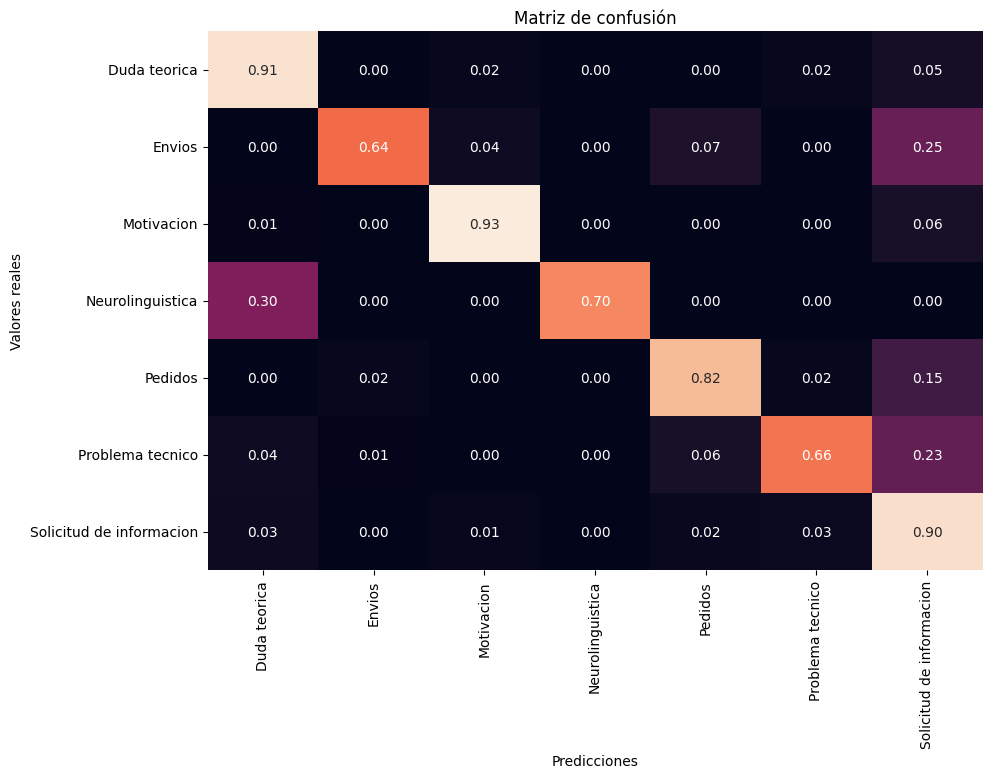

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cr = classification_report(final_truelabel_list,
                           final_prediction_list,
                           output_dict=False)
print(cr)


# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(final_truelabel_list, final_prediction_list)

# Normalizamos la matriz de confusión
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

In [ ]:
# Entrenamiento
import time
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss

train_loss_values = []
val_loss_values = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stop_thresh = 3
best_accuracy = -1
best_loss = np.inf
best_epoch = 0

loss_fn = CrossEntropyLoss(weight=weights)

# Iteramos las épocas
for epoch_i in range(0, epochs):

    print('Entrenando en época: ', epoch_i)
    t0 = time.time()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    val_accuracy = 0
    bert.train()
    for batch in train_bert_dataloader:

        # Cargamos los datos
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        bert.zero_grad()
        # Obtenemos los outputs
        outputs = bert(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels.long())

        # Obtenemos la pérdida
        loss = loss_fn(outputs.logits, b_labels.long())

        total_correct += (outputs[1].argmax(dim=-1) == b_labels).sum().item()
        total_samples += len(b_labels)
        total_loss += loss.item()

        # Hacemos backpropagation de los gradientes
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)
        # Actualizamos el optimizador
        optimizer_bert.step()
        # Actualizamos el learning rate
        scheduler.step()

    # Calculamos la pérdida media en el conjunto de entrenamiento
    avg_train_loss = total_loss / len(train_bert_dataloader)
    train_loss_values.append(avg_train_loss)
    print("Training Loss: {0:.2f}".format(avg_train_loss))
    print("Training Accuracy: {0:.2f}".format(total_correct/total_samples))

    # Calculamos los datos sobre validación
    bert.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in val_bert_dataloader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      with torch.no_grad():
        outputs = bert(b_input_ids, token_type_ids=None,attention_mask=b_input_mask, labels=b_labels.long())

      # Obtenemos la pérdida
      loss = loss = loss_fn(outputs.logits, b_labels.long())
      total_eval_loss += loss.item()

      logits = outputs[1]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      final_prediction = np.argmax(logits, axis=-1).flatten()
      val_accuracy+= accuracy_score(final_prediction,label_ids)

    avg_val_loss =  total_eval_loss / len(val_bert_dataloader)
    val_loss_values.append(avg_val_loss)
    val_accuracy/= len(val_bert_dataloader)
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation Accuracy: {0:.2f}".format(val_accuracy))

    print('Tiempo de entrenamiento en esta época: {0:.2f} s'.format(time.time() - t0))
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_loss = avg_val_loss
        best_epoch = epoch_i
        print("best_accuracy: ", best_accuracy)
        print("best_epoch: ", best_epoch)
        checkpoint(bert, "/Users/34653/Desktop/bert_weights.pth")
    elif epoch_i - best_epoch > early_stop_thresh:
        print("epoch_i: ", epoch_i, " - best_epoch: ", best_epoch, " > early_stop_thresh: ", early_stop_thresh)
        print("Early stopped training at epoch %d" % epoch_i)
        break
resume(bert, "/Users/34653/Desktop/bert_weights.pth")

Entrenando en época:  0
Training Loss: 0.04
Training Accuracy: 0.99
Validation Loss: 1.56
Validation Accuracy: 0.86
Tiempo de entrenamiento en esta época: 61.58 s
best_accuracy:  0.8557692307692307
best_epoch:  0
Entrenando en época:  1
Training Loss: 0.04
Training Accuracy: 0.99
Validation Loss: 1.55
Validation Accuracy: 0.86
Tiempo de entrenamiento en esta época: 60.73 s
best_accuracy:  0.8632478632478633
best_epoch:  1
Entrenando en época:  2
Training Loss: 0.02
Training Accuracy: 1.00
Validation Loss: 1.59
Validation Accuracy: 0.86
Tiempo de entrenamiento en esta época: 60.64 s
best_accuracy:  0.8643162393162394
best_epoch:  2
Entrenando en época:  3
Training Loss: 0.02
Training Accuracy: 1.00
Validation Loss: 1.61
Validation Accuracy: 0.85
Tiempo de entrenamiento en esta época: 60.51 s
Entrenando en época:  4
Training Loss: 0.03
Training Accuracy: 0.99
Validation Loss: 1.72
Validation Accuracy: 0.86
Tiempo de entrenamiento en esta época: 60.55 s
Entrenando en época:  5
Training Lo

In [ ]:
# Test
import numpy as np
t0 = time.time()
bert.eval()
# Guardamos predicciones
predictions,true_labels =[],[]

for batch in test_bert_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = bert(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    # Obtenemos los outputs
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)

print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 2.50 s


In [ ]:
# Convertimos las etiquetas a strings
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

                          precision    recall  f1-score   support

            Duda teorica       0.95      0.83      0.89       331
                  Envios       0.59      0.57      0.58        28
              Motivacion       0.93      0.88      0.90       149
        Neurolinguistica       1.00      0.80      0.89        10
                 Pedidos       0.65      0.82      0.72        65
        Problema tecnico       0.72      0.67      0.70       166
Solicitud de informacion       0.87      0.93      0.90       653

                accuracy                           0.86      1402
               macro avg       0.82      0.79      0.80      1402
            weighted avg       0.86      0.86      0.86      1402



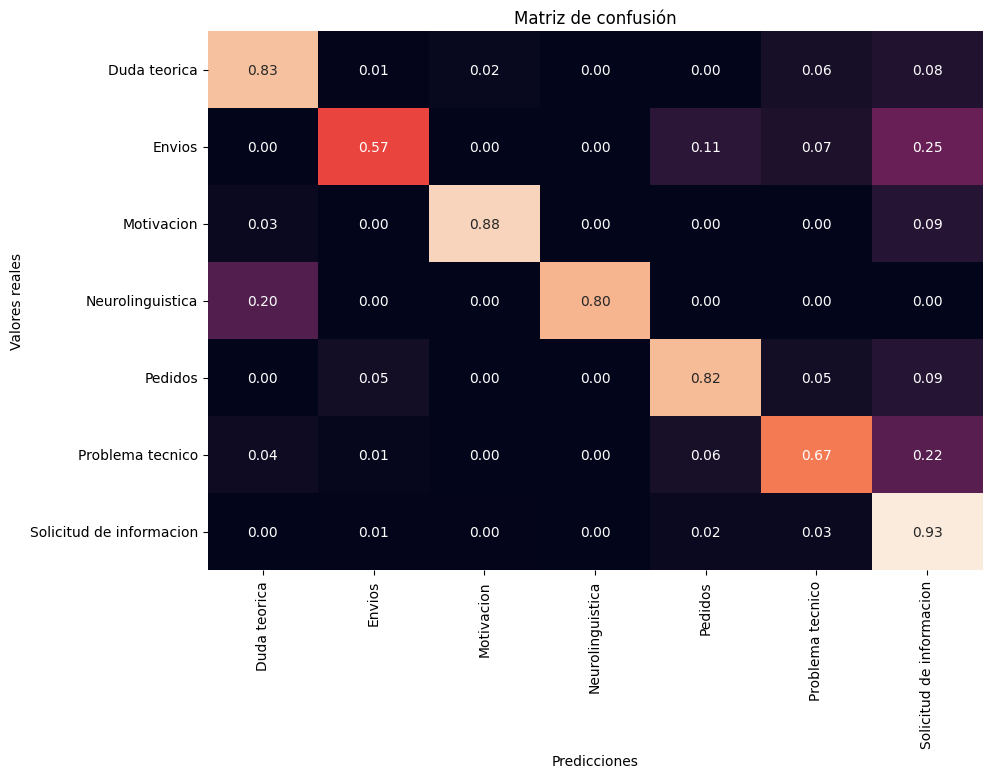

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cr = classification_report(final_truelabel_list,
                           final_prediction_list,
                           output_dict=False)
print(cr)


# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(final_truelabel_list, final_prediction_list)

# Normalizamos la matriz de confusión
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()